`Cortix` 2019 **07Aug2019**

# Droplet Swirl Example
* This is part of the [Cortix](https://cortix.org) Notebook [guides](https://github.com/dpploy/cortix-nb)
([index](https://github.com/dpploy/cortix-nb/blob/master/droplet.ipynb)).
* Select each of the cells below and run them sequentially (use the run button, `>|` on the tool bar or use the `Cell` option on the menu bar).
* Alternatively, on the menu bar run all cells: `Cell -> Run All`.

$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\vvar}{\boldsymbol{v}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\Power}{\mathcal{P}}
  \newcommand{\bm}[1]{{\boldsymbol{#1}}}
$

---
## Table of Contents
* [Introduction](#intro)
  - [Droplet motion model](#dropletmodel)
  - [Vortex motion model](#vortexmodel)
* [Write a Cortix run file](#runfile)
* [Verify the network connectivity](#net)
* [Run the network simulation](#run)
* [Results inspection through Cortix](#inspect)
   - [Results: All droplets](#dataplot)
   - [Results: Individual droplets](#droplet)
---

## Introduction<a id="intro"></a>

This Cortix use-case simulates the motion of a swarm of droplets in a vortex stream. 
It consists of two modules, namely, a `Droplet` module used to model the droplet dynamics, 
and a `Vortex` module used to model the effects of the surrounding air on the falling 
droplets. The `Droplet` module is instantiated as many times as there are droplets in 
the simulation while a single `Vortex` module is connected to all `Droplet` 
instances. The communication between modules entails a two-way data exchange between 
the `Vortex` module and the `Droplet` modules, where `Droplet` sends  
its position to `Vortex` and `Vortex` returns the air velocity to `Droplet` at the given position.

### Droplet motion model<a id="dropletmodel"></a>

The equation of motion of a spherical droplet can be written as:
    \begin{equation*}
        m_\text{d}\,d_t\bm{v} = \bm{f}_\text{d} + \bm{f}_\text{b} ,
    \end{equation*}
where
   \begin{equation*}
       \bm{f}_\text{d} = c_\text{d} A \, \rho_\text{f}\, 
       \frac{||\bm{v} - \bm{v}_\text{f}||}{2}\,(\bm{v} - \bm{v}_\text{f}) ,
    \end{equation*}
is the form drag force on the droplet,
    \begin{equation*}
    \bm{f}_\text{b} = (m_\text{d} - m_\text{f})\,g \hat{z} ,
    \end{equation*} 
is the buoyancy force on the droplet,
    \begin{equation*}
        c_\text{d}(Re) = 
    \begin{cases}
        \frac{24}{Re}   & Re < 0.1\\
        \Bigl(\sqrt{\frac{24}{Re}} + 0.5407\Bigr)^2 & 0.1 \leq Re < 6000 \\
        0.44    & Re \geq 6000
    \end{cases}
    \end{equation*}
is the drag coefficient as a function of Reynold's number, 
$Re=\frac{\rho_\text{f}\,||\bm{v}||\,d}{\mu_\text{f}}$.
The mass of the droplet and its displaced fluid mass are denoted $m_d$ and $m_f$,
respectively. Droplet diameter, $d$, dynamic viscosity, $\mu_\text{f}$, and 
mass density, $\rho_\text{f}$, of the surrounding air are provided.

### Vortex motion model<a id="vortexmodel"></a>

Here we simply use an imposed vortex circulation in analytical form given by its 
tangential component of velocity
    \begin{equation*}
        v_\theta(r,z,t) = \Bigl(1 - e^{\frac{-r^2}{8\,r_c^2}}\Bigr) 
        \frac{\Gamma}{2\pi\, \max(r,r_c)} f(z) \, \bigl|\cos(\mu\,t)\bigr|,
    \end{equation*}
and its vertical component
    \begin{equation*}
        v_z(z,t) = v_h \, f(z) \, \bigl|\cos(\mu\,t)\bigr|,
    \end{equation*}
where 
    \begin{equation*}
        f(z) = e^{\frac{-(h - z)}{\ell}}
    \end{equation*}
    is a vertical relaxation factor, $r_c$ is the vortex core radius,
    $\Gamma = \frac{2\pi R}{v_\theta |_{r = R}}$ is the vortex circulation,
    $R$ is the vortex outer radius,
    $h$ is the height of the vortex, and
    $\ell$ is the relaxation length of $v_z$.

## Write the run context<a id="runfile"></a>

In [1]:
# Import various packages; must have the Cortix repository installed

import scipy.constants as const
import matplotlib.pyplot as plt
    
from cortix.src.cortix_main import Cortix
from cortix.src.network import Network

# Import the example modules
from cortix.examples.vortex import Vortex
from cortix.examples.droplet import Droplet

In [2]:
# Create a Cortix object with Python multiprocessing

swirl = Cortix(use_mpi=False,splash=True)

swirl.network = Network()
swirl_net = swirl.network

# Set parameters in SI units

n_droplets = 15
end_time = 3*const.minute
time_step = 0.2

[2417] 2019-08-14 15:04:39,723 - cortix - INFO - Created Cortix object 
_____________________________________________________________________________
                             L A U N C H I N G                               
_____________________________________________________________________________
      ...                                        s       .     (TAAG Fraktur)
   xH88"`~ .x8X                                 :8      @88>
 :8888   .f"8888Hf        u.      .u    .      .88      %8P      uL   ..
:8888>  X8L  ^""`   ...ue888b   .d88B :@8c    :888ooo    .     .@88b  @88R
X8888  X888h        888R Y888r ="8888f8888r -*8888888  .@88u  ""Y888k/"*P
88888  !88888.      888R I888>   4888>"88"    8888    888E`    Y888L
88888   %88888      888R I888>   4888> "      8888      888E      8888
88888 `> `8888>     888R I888>   4888>        8888      888E      `888N
`8888L %  ?888   ! u8888cJ888   .d888L .+    .8888Lu=   888E   .u./"888&
 `8888  `-*""   /   "*888*P"    ^"8888*"     ^%8

In [3]:
# Create the application network

# Vortex module (single)
vortex = Vortex()
swirl_net.module(vortex)
vortex.show_time = (True,1*const.minute)
vortex.end_time = end_time
vortex.time_step = time_step
vortex.plot_velocity()

for i in range(n_droplets):
    
    # Droplet modules (multiple)
    droplet = Droplet()
    swirl_net.module(droplet)
    droplet.end_time = end_time
    droplet.time_step = time_step
    droplet.bounce = False        # allow droplets to bounce off the ground
    droplet.slip = False          # allow droplets to slip on the ground (otherwise will stick)
    
    swirl_net.connect( [droplet, 'external-flow'], [vortex, vortex.get_port('fluid-flow:{}'.format(i))],
                       'bidirectional')

## Verify the network connectivity<a id="net"></a>

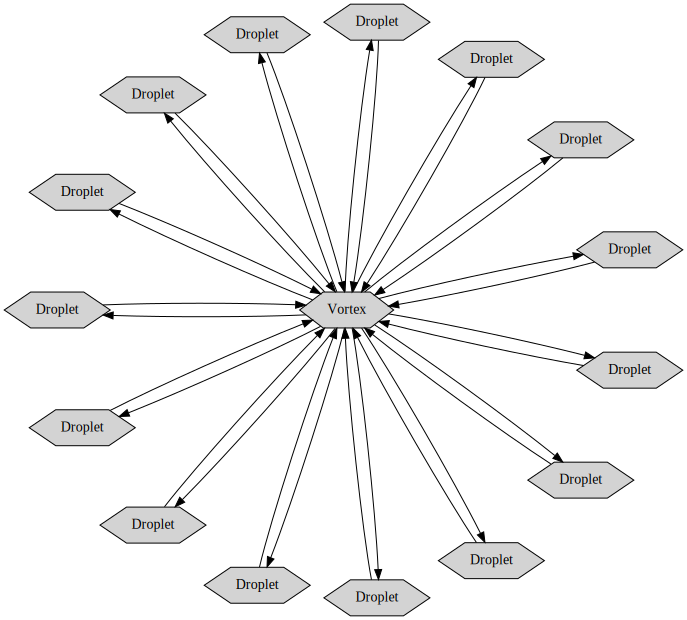

In [4]:
# View the Cortix network created

swirl_net.draw()

## Run network simulation<a id="run"></a>

In [5]:
# Run the simulation!

swirl.run()

[2417] 2019-08-14 15:04:40,219 - cortix - INFO - Launching Module <cortix.examples.vortex.Vortex object at 0x7f9aa1a1cd90>
[2417] 2019-08-14 15:04:40,226 - cortix - INFO - Vortex::time[min] = 0.0
[2417] 2019-08-14 15:04:40,224 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x7f9aa26b1490>
[2417] 2019-08-14 15:04:40,235 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x7f9a9edc5a90>
[2417] 2019-08-14 15:04:40,243 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x7f9a9edcb210>
[2417] 2019-08-14 15:04:40,249 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x7f9a9edd2550>
[2417] 2019-08-14 15:04:40,255 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x7f9a9edd5350>
[2417] 2019-08-14 15:04:40,262 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x7f9a9edd54d0>
[2417] 2019-08-14 15:04:40,269 - cortix - INFO - Launc

## Results inspection through Cortix<a id="inspect"></a>

### All droplets<a id="dataplot"></a>

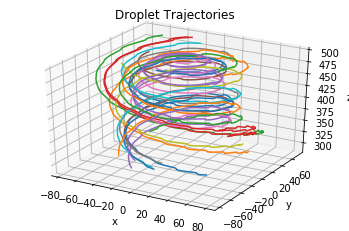

In [6]:
'''All droplets' trajectory'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

position_histories = list()
for m in swirl_net.modules[1:]:
    position_histories.append( m.state.get_quantity_history('position')[0].value )
    
fig = plt.figure(1)
ax = fig.add_subplot(111,projection='3d')
ax.set_title('Droplet Trajectories')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
for p in position_histories:
    x = [u[0] for u in p]
    y = [u[1] for u in p]
    z = [u[2] for u in p]
    ax.plot(x,y,z)
plt.rcParams['figure.figsize'] = [10,10]
plt.show()

Trajectories of all droplets released from random positions at 500-m altitude. Multiprocessing parallel run with number of processes corresponding to all modules: all `Droplet` modules, 1 `Vortex` module,
and 1 Cortix master process.

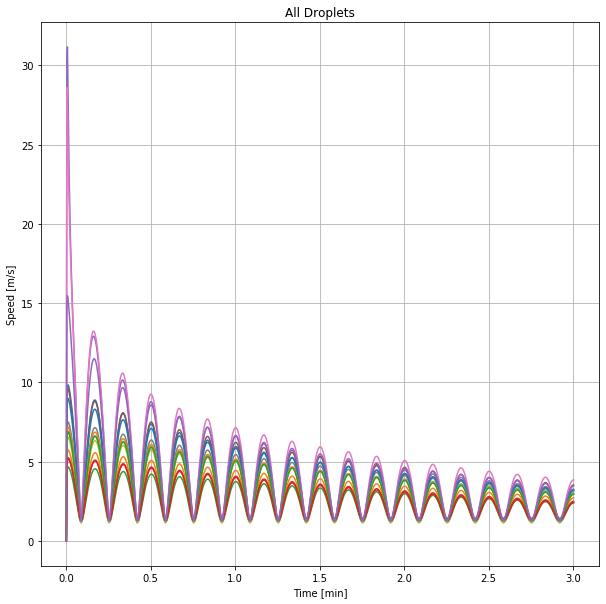

In [7]:
'''All droplets' speed'''

fig = plt.figure(2)
plt.xlabel('Time [min]')
plt.ylabel('Speed [m/s]')
plt.title('All Droplets')

for m in swirl_net.modules[1:]:
    speed_series = m.state.get_quantity_history('speed')[0].value
    x = list(p.index/60)
    y = list(speed_series[:])
    plt.plot(x,y)

plt.rcParams['figure.figsize'] = [8,5]
plt.grid()
plt.show()

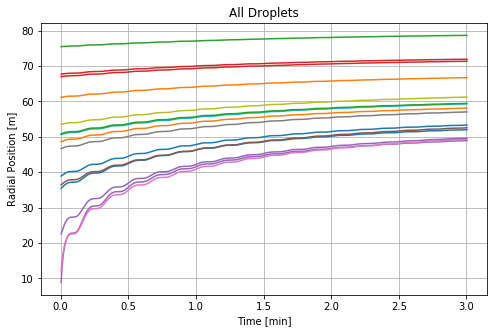

In [8]:
'''All droplets' radial position'''

fig = plt.figure(3)
plt.xlabel('Time [min]')
plt.ylabel('Radial Position [m]')
plt.title('All Droplets')

for m in swirl_net.modules[1:]:
    speed_series = m.state.get_quantity_history('radial-position')[0].value
    x = list(p.index/60)[1:]
    y = list(speed_series[:])[1:]
    plt.plot(x,y)

plt.rcParams['figure.figsize'] = [8,5]
plt.grid()
plt.show()

### Individual droplet modules<a id="droplet"></a>

time unit =  s
speed unit =  m/s


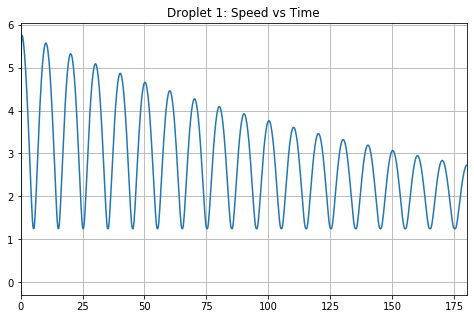

In [9]:
'''Droplet 1 Module State'''

droplet_1 = swirl_net.modules[2]
(speed_quant,time_unit) = droplet_1.state.get_quantity_history('speed')
print('time unit = ',time_unit)
print('speed unit = ',speed_quant.unit)
speed = speed_quant.value
speed.plot(title='Droplet 1: Speed vs Time')
plt.rcParams['figure.figsize'] = [8,5]
plt.grid()
plt.show()

time unit =  s
rad. pos. unit =  m


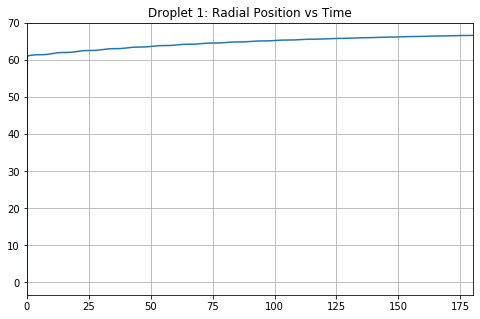

In [10]:
(radial_position_quant,time_unit) = droplet_1.state.get_quantity_history('radial-position')
print('time unit = ',time_unit)
print('rad. pos. unit = ',radial_position_quant.unit)
rad_pos = radial_position_quant.value
rad_pos.plot(title='Droplet 1: Radial Position vs Time')
plt.rcParams['figure.figsize'] = [8,5]
plt.grid()
plt.show()

# Droplet at Scale

Below is a graph of the number of droplets in the system vs the elapsed time of the corresponding simulation.

**Data collected courtesy of the Idaho National Labs HPC center (https://hpc.inl.gov)**

Average number of droplets handled per second: 2.03


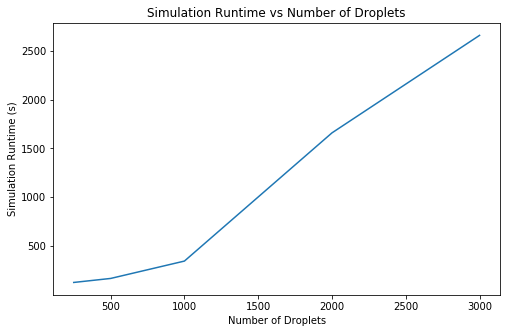

In [11]:
import matplotlib.pyplot as plt

# Droplet number vs Simulation runtimes 
droplet_run_times = [(250, 127), (500, 168), (1000, 346), (2000, 1660), (3000, 2659.24)]

# Calculate the average runtime per droplet
drops_per_sec = [x/y for (x,y) in droplet_run_times]
avg_drop_per_sec = sum(drops_per_sec) / len(drops_per_sec)
print("Average number of droplets handled per second: %.2f" % avg_drop_per_sec)

plt.plot([x for (x, y) in droplet_run_times], [y for (x, y) in droplet_run_times])
plt.title("Simulation Runtime vs Number of Droplets")
plt.xlabel("Number of Droplets")
plt.ylabel("Simulation Runtime (s)")
plt.savefig("droplet_trend.png")
plt.show()